# Imports and setup

In [1]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math
import pandas as pd
import matplotlib.pyplot as plt

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, classification_report)

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chibu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1: Preprocess and Save Processed Data to CSV 

##### Functions to preprocess data

In [2]:
########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}  # Define your custom stopwords here
    stop_words.update(custom_stopwords)
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

def check_data_leakage(X_train, X_test):
    train_set = set(map(tuple, X_train))
    test_set = set(map(tuple, X_test))

    leaked_samples = train_set.intersection(test_set)
    print("\n🔍 Checking Data Leakage...")
    print(f"⚠️ {len(leaked_samples)} samples from test data are also in training data.")

    if len(leaked_samples) > 0:
        print("❌ Data Leakage Detected! Test data should not exist in training set.")
    else:
        print("✅ No Data Leakage Detected.")

##COMAPRES TEST ACCURACY TO TRAIN ACCURACY
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    print("\n🔍 Checking Overfitting...")
    print(f"📊 Training Accuracy: {train_acc:.4f}")
    print(f"📊 Test Accuracy: {test_acc:.4f}")

    if train_acc > test_acc + 0.10:
        print("❌ Possible Overfitting: Model performs much better on training data.")
    else:
        print("✅ No significant overfitting detected.")

# Line Chart (Trend over Repeats)
def plot_metric_trends(csv_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(8, 4))
    metric_columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

    for metric in metric_columns:
        plt.plot(df['Repeat'], df[metric], marker='o', label=metric)

    # Chart styling
    plt.xlabel("Repeat")
    plt.ylabel("Score")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(metric_columns), frameon=False)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

##### Download and read data, save to csv files for repeatable use

In [3]:
########## 3. Download & read data ##########
project = 'incubator-mxnet'
text_col = 'Title+Body'


In [5]:
path = f'C:/Users/chibu/Documents/ISE-solution-main/Coursework/datasets/{project}.csv'

data = pd.read_csv(path).fillna('')
data['Title+Body'] = data.apply(lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'], axis=1)
#text_col = 'Title+Body'

data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

data.to_csv(f'{project}_processed_data.csv', index=False)


##### Load and check datasets in Title+Body Files

In [4]:
baseline_path = 'C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2'

df = pd.read_csv(f'{project}_processed_data.csv')
df.head()

,Unnamed: 0,Repository,Number,State,Title,Body,Labels,Comments,Codes,Commands,class,related,Title+Body
0,0,incubator-mxnet,9216,closed,Loss of Precision in BatchNorm and output_var ...,## Description\r\n1. BatchNorm loses a little ...,Bug,"[""What's the result if we use this line instea...",['\r\ncaffe and numpy 0.0 0.0\r\ncaffe and mx ...,"['(x - mean(x)) / sqrt(var(x) + eps)', '(x - m...",1,1,loss precision batchnorm output var may wrong....
1,1,incubator-mxnet,10881,closed,mx.sym.dot() performance on CPU,We are using mx.sym.dot() operator in Keras he...,Backend Operator Performance,['I see that we are still using mshadow dot he...,[],[],1,0,mx.sym.dot( ) performance cpu. using mx.sym.do...
2,2,incubator-mxnet,10368,closed,asscalar is very slow,"The train part cost 0.01 second, but the assca...",NaN,['How did you time it? `asscalar` is a blockin...,[' python\r\n for epoch in range(num_epochs...,[],1,0,"asscalar slow. train part cost 0.01 second, as..."
3,3,incubator-mxnet,3591,closed,In R prediction is running only on CPU very sow,I have quite a deep net trained on 4 gpus whic...,NaN,"['`predict(model, X, mx.gpu())`\n', 'too easy....",[],[],1,0,r prediction running cpu sow. quite deep net t...
4,4,incubator-mxnet,13449,closed,significant performance regression in SpMV,It seems https://github.com/apache/incubator-m...,Performance,['@zheng-da Thank you for reporting the regres...,['\r\npython3 sse_batch.py --graph-file ../../...,[],1,1,significant performance regression spmv. seems...


### Step 2: Configure parameters and start training

##### Set values, params and load csv files

In [7]:
# Number of repeated experiments
REPEAT = 30

# Output CSV file name
results_dir = "C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2/results"
out_csv_name = f"{results_dir}/{project}_Results.csv"

# Convert and save metrics for all models
def save_model_metrics(metrics_list, filename):
    df = pd.DataFrame(metrics_list)
    df.to_csv(f"{results_dir}/{filename}", index=False)
    print(f"Saved: {filename}")
    print(df.mean(numeric_only=True))
    print("\n")

# Hyperparameter grid for Naive Bayes
params = {'var_smoothing': np.logspace(-12, 0, 13)}

# Lists to store metrics across repeated runs
accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

##### Perform Testing on Baseline code from Lab 1

In [8]:
nb_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X = data[text_col]
y = data['class']

for repeated_time in range(REPEAT):
    

    # Train-test split (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Train and Evaluate Naive Bayes with Cross-Validation
    nb_clf = GaussianNB()
    grid = GridSearchCV(nb_clf, params, cv=5, scoring='roc_auc')
    grid.fit(X_train_tfidf, y_train)
    best_nb = grid.best_estimator_
    y_pred_nb = best_nb.predict(X_test_tfidf)
    
    nb_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test, y_pred_nb),
        "Precision": precision_score(y_test, y_pred_nb, average='macro'),
        "Recall": recall_score(y_test, y_pred_nb, average='macro'),
        "F1": f1_score(y_test, y_pred_nb, average='macro'),
        "AUC": auc(*roc_curve(y_test, y_pred_nb, pos_label=1)[:2])
    })

    save_model_metrics(nb_metrics, f'{project}_NaiveBayes_Metrics.csv')

Saved: incubator-mxnet_NaiveBayes_Metrics.csv
Repeat       0.000000
Accuracy     0.625806
Precision    0.632911
Recall       0.783582
F1           0.571905
AUC          0.783582
dtype: float64


Saved: incubator-mxnet_NaiveBayes_Metrics.csv
Repeat       0.500000
Accuracy     0.600000
Precision    0.599725
Recall       0.731607
F1           0.530916
AUC          0.731607
dtype: float64


Saved: incubator-mxnet_NaiveBayes_Metrics.csv
Repeat       1.000000
Accuracy     0.584946
Precision    0.599429
Recall       0.737738
F1           0.520072
AUC          0.737738
dtype: float64


Saved: incubator-mxnet_NaiveBayes_Metrics.csv
Repeat       1.500000
Accuracy     0.593548
Precision    0.598732
Recall       0.743333
F1           0.523818
AUC          0.743333
dtype: float64


Saved: incubator-mxnet_NaiveBayes_Metrics.csv
Repeat       2.000000
Accuracy     0.597419
Precision    0.600039
Recall       0.751501
F1           0.526314
AUC          0.751501
dtype: float64


Saved: incubator-mxnet_Na

##### View progressive results

In [9]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')
df.head() 

,Repeat,Accuracy,Precision,Recall,F1,AUC
0,0,0.625806,0.632911,0.783582,0.571905,0.783582
1,1,0.574194,0.566539,0.679631,0.489928,0.679631
2,2,0.554839,0.598837,0.750000,0.498382,0.750000
3,3,0.619355,0.596642,0.760117,0.535055,0.760117
4,4,0.612903,0.605263,0.784173,0.536298,0.784173


##### Save final results to csv file

In [10]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in nb_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in nb_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in nb_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in nb_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in nb_metrics])
}

save_model_metrics([final_metrics], f'{project}_NaiveBayes_Final_Metrics.csv')

Saved: incubator-mxnet_NaiveBayes_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.568172
Avg_Precision     0.601485
Avg_Recall        0.730663
Avg_F1            0.512395
Avg_AUC           0.730663
dtype: float64




##### Load results for baseline 

In [11]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.568172,0.601485,0.730663,0.512395,0.730663


### Examine datasets for data leakage and overfitting and class ditribution to know what to expect when it comes to validating my results based on baseline

In [12]:


#check where these variables are coming from
# For baseline Naive Bayes testing:
check_data_leakage(X_train_tfidf, X_test_tfidf)
check_overfitting(best_nb, X_train_tfidf, y_train, X_test_tfidf, y_test)

print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))


🔍 Checking Data Leakage...
⚠️ 1 samples from test data are also in training data.
❌ Data Leakage Detected! Test data should not exist in training set.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.7175
📊 Test Accuracy: 0.6645
✅ No significant overfitting detected.

Class Distribution in Training Set:
class
0    322
1     39
Name: count, dtype: int64

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       129
           1       0.33      0.96      0.49        26

    accuracy                           0.66       155
   macro avg       0.66      0.78      0.62       155
weighted avg       0.88      0.66      0.71       155



##### Line chart repeats

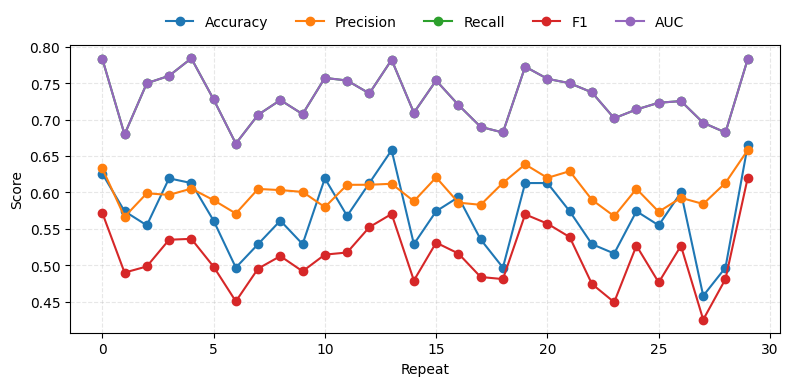

In [5]:
plot_metric_trends(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')

##### Perform Testing with Random Forest

In [13]:
rf_metrics = []

# Load dataset for this iteration
data_rf = pd.read_csv(f'{project}_processed_data.csv')
X_rf = data_rf[text_col]
y_rf = data_rf['class']

for repeated_time in range(REPEAT):
    
    # Train-test split (70/30)
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
        X_rf, y_rf, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf_rf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_rf = tfidf_rf.fit_transform(X_train_rf).toarray()
    X_test_tfidf_rf = tfidf_rf.transform(X_test_rf).toarray()

    # Train and Evaluate Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf.fit(X_train_tfidf_rf, y_train_rf)
    y_pred_rf = rf_clf.predict(X_test_tfidf_rf)

    rf_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_rf, y_pred_rf),
        "Precision": precision_score(y_test_rf, y_pred_rf, average='macro'),
        "Recall": recall_score(y_test_rf, y_pred_rf, average='macro'),
        "F1": f1_score(y_test_rf, y_pred_rf, average='macro'),
        "AUC": auc(*roc_curve(y_test_rf, y_pred_rf, pos_label=1)[:2])
    })

    save_model_metrics(rf_metrics, f'{project}_RandomForest_Metrics.csv')


Saved: incubator-mxnet_RandomForest_Metrics.csv
Repeat       0.000000
Accuracy     0.858065
Precision    0.600877
Recall       0.516347
F1           0.503205
AUC          0.516347
dtype: float64


Saved: incubator-mxnet_RandomForest_Metrics.csv
Repeat       0.500000
Accuracy     0.864516
Precision    0.589129
Recall       0.528632
F1           0.525787
AUC          0.528632
dtype: float64


Saved: incubator-mxnet_RandomForest_Metrics.csv
Repeat       1.000000
Accuracy     0.868817
Precision    0.583426
Recall       0.525269
F1           0.522107
AUC          0.525269
dtype: float64


Saved: incubator-mxnet_RandomForest_Metrics.csv
Repeat       1.500000
Accuracy     0.874194
Precision    0.549582
Recall       0.518052
F1           0.509328
AUC          0.518052
dtype: float64


Saved: incubator-mxnet_RandomForest_Metrics.csv
Repeat       2.000000
Accuracy     0.876129
Precision    0.529208
Recall       0.513003
F1           0.501298
AUC          0.513003
dtype: float64


Saved: incubato

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Save results to csv file

In [14]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in rf_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in rf_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in rf_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in rf_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in rf_metrics])
}

save_model_metrics([final_metrics], f'{project}_RandomForest_Final_Metrics.csv')

Saved: incubator-mxnet_RandomForest_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.870968
Avg_Precision     0.645722
Avg_Recall        0.524621
Avg_F1            0.516984
Avg_AUC           0.524621
dtype: float64




##### Load results for Random Forest 

In [15]:
df = pd.read_csv(f'{baseline_path}/results/{project}_RandomForest_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.870968,0.645722,0.524621,0.516984,0.524621


##### My own improvement: perform testing with the hybrid Model 

In [16]:
hybrid_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X_hybrid = data[text_col]
y_hybrid = data['class']

for repeated_time in range(REPEAT):
    

    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid, y_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[('rf', rf_clf_hybrid), ('logreg', logreg_clf_hybrid)], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

    save_model_metrics(hybrid_metrics, f'{project}_HybridModel_Metrics.csv')


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       0.000000
Accuracy     0.864516
Precision    0.432258
Recall       0.500000
F1           0.463668
AUC          0.500000
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       0.500000
Accuracy     0.874194
Precision    0.503795
Recall       0.510229
F1           0.491317
AUC          0.510229
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       1.000000
Accuracy     0.879570
Precision    0.568434
Recall       0.515416
F1           0.502018
AUC          0.515416
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       1.500000
Accuracy     0.883871
Precision    0.538422
Recall       0.511562
F1           0.494711
AUC          0.511562
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       2.000000
Accuracy     0.886452
Precision    0.520415
Recall       0.509249
F1           0.490327
AUC          0.509249
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       2.500000
Accuracy     0.888172
Precision    0.591688
Recall       0.512610
F1           0.496632
AUC          0.512610
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       3.000000
Accuracy     0.887558
Precision    0.570295
Recall       0.510808
F1           0.492710
AUC          0.510808
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       3.500000
Accuracy     0.882258
Precision    0.552521
Recall       0.508518
F1           0.488376
AUC          0.508518
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       4.000000
Accuracy     0.878136
Precision    0.539327
Recall       0.505925
F1           0.485006
AUC          0.505925
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       4.500000
Accuracy     0.876774
Precision    0.528620
Recall       0.505333
F1           0.482872
AUC          0.505333
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       5.000000
Accuracy     0.880352
Precision    0.522206
Recall       0.504848
F1           0.482440
AUC          0.504848
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       5.500000
Accuracy     0.880108
Precision    0.515248
Recall       0.504444
F1           0.481183
AUC          0.504444
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       6.000000
Accuracy     0.877916
Precision    0.508796
Recall       0.503528
F1           0.479548
AUC          0.503528
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       6.500000
Accuracy     0.878341
Precision    0.504225
Recall       0.503017
F1           0.478807
AUC          0.503017
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       7.000000
Accuracy     0.878710
Precision    0.500073
Recall       0.502816
F1           0.478165
AUC          0.502816
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       7.500000
Accuracy     0.877823
Precision    0.495834
Recall       0.502640
F1           0.477259
AUC          0.502640
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       8.000000
Accuracy     0.878558
Precision    0.492853
Recall       0.502485
F1           0.476890
AUC          0.502485
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       8.500000
Accuracy     0.878495
Precision    0.489845
Recall       0.502347
F1           0.476360
AUC          0.502347
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       9.000000
Accuracy     0.876061
Precision    0.485966
Recall       0.502223
F1           0.475195
AUC          0.502223
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       9.500000
Accuracy     0.874839
Precision    0.482958
Recall       0.502112
F1           0.474432
AUC          0.502112
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       10.000000
Accuracy      0.874347
Precision     0.480543
Recall        0.502011
F1            0.473920
AUC           0.502011
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       10.500000
Accuracy      0.873021
Precision     0.478033
Recall        0.501748
F1            0.473198
AUC           0.501748
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       11.000000
Accuracy      0.874053
Precision     0.476744
Recall        0.501672
F1            0.473180
AUC           0.501672
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       11.500000
Accuracy      0.875538
Precision     0.475832
Recall        0.501602
F1            0.473312
AUC           0.501602
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       12.000000
Accuracy      0.874839
Precision     0.473960
Recall        0.501538
F1            0.472852
AUC           0.501538
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       12.500000
Accuracy      0.876179
Precision     0.473224
Recall        0.501479
F1            0.472987
AUC           0.501479
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       13.000000
Accuracy      0.876464
Precision     0.472065
Recall        0.501424
F1            0.472846
AUC           0.501424
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       13.500000
Accuracy      0.876728
Precision     0.471092
Recall        0.501244
F1            0.472715
AUC           0.501244
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       14.000000
Accuracy      0.875195
Precision     0.469197
Recall        0.501201
F1            0.472077
AUC           0.501201
dtype: float64


Saved: incubator-mxnet_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.873763
Precision     0.467428
Recall        0.501161
F1            0.471482
AUC           0.501161
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Save results to csv file

In [17]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_HybridModel_Final_Metrics.csv')

Saved: incubator-mxnet_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.873763
Avg_Precision     0.467428
Avg_Recall        0.501161
Avg_F1            0.471482
Avg_AUC           0.501161
dtype: float64




##### Line chart repeats

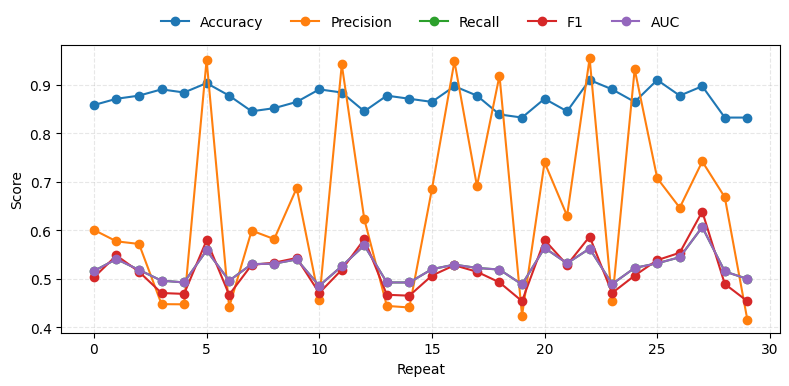

In [6]:
plot_metric_trends(f'{baseline_path}/results/{project}_RandomForest_Metrics.csv')

##### Load results for Hybrid Model 

In [18]:
df = pd.read_csv(f'{baseline_path}/results/{project}_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.873763,0.467428,0.501161,0.471482,0.501161


##### Line chart repeats

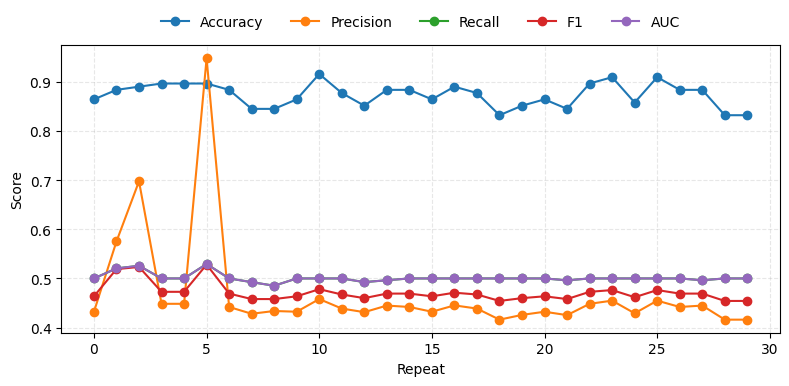

In [7]:
plot_metric_trends(f'{baseline_path}/results/{project}_HybridModel_Metrics.csv')

### Step 3: Validate results

###### Now that the training has been complete with the baselineto be able to compare with my own improvements. 
###### I want to ensure my results can be trusted so, FOR THE HYBRID MODEL, I will test on holdout data, check for data leakage an overfitting. I will also check the class distribution of the training set and perfrom SMOTE to Balance the dataset and retest witht the hybrid model, to see if there any differences in results

##### Test Hybrid Model on Holdout Data ---Shoukld this repeat 30 times???

In [19]:
###0 IS A NONBUG, SO IT IS WHAT SHOULD BE PRE4DICTED AS NONBUG

# Define function to test trained hybrid model on holdout set
def test_on_holdout_hybrid(model):
    holdout_data_hybrid = pd.read_csv(f'{project}_processed_data_holdout.csv')
    holdout_text_hybrid = holdout_data_hybrid[text_col]
    holdout_labels_hybrid = holdout_data_hybrid['class']

    tfidf_hybrid_holdout = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_holdout_hybrid = tfidf_hybrid_holdout.fit_transform(holdout_text_hybrid).toarray()

    holdout_preds_hybrid = model.predict(X_holdout_hybrid)
    print("\n🔍 Holdout Set Performance (Hybrid Model):")
    print(classification_report(holdout_labels_hybrid, holdout_preds_hybrid, target_names=['Non-Bug', 'Bug']))

    # Load full processed dataset
data = pd.read_csv(f'{project}_processed_data.csv')

# Create holdout split (90% train/test, 10% holdout)
train_test_data, holdout_data = train_test_split(data, test_size=0.1, random_state=42)

# Save to CSV for consistent usage across notebooks
train_test_data.to_csv(f'{project}_processed_train_test_data_holdout.csv', index=False)
holdout_data.to_csv(f'{project}_processed_data_holdout.csv', index=False)




hybrid_holdout_metrics = []

# Load 90% dataset for training/testing splits
data_hybrid_holdout = pd.read_csv(f'{project}_processed_train_test_data_holdout.csv')
X_hybrid_holdout = data_hybrid_holdout[text_col]
y_hybrid_holdout = data_hybrid_holdout['class']

for repeated_time in range(REPEAT):
    # Split into 70/30
    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid_holdout, y_hybrid_holdout, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF
    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    # Random Forest
    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    # Hybrid Model: Random Forest + Logistic Regression
    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[
        ('rf', rf_clf_hybrid), 
        ('logreg', logreg_clf_hybrid)
    ], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)
    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    # Save metrics for each repeat
    hybrid_holdout_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

# Save all repeated metrics to CSV
#save_model_metrics(hybrid_holdout_metrics, f'{project}_HybridModel_Holdout_Metrics.csv')



# Evaluate on true holdout portion
test_on_holdout_hybrid(voting_clf_hybrid)


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: Unde


🔍 Holdout Set Performance (Hybrid Model):
              precision    recall  f1-score   support

     Non-Bug       0.92      1.00      0.96        48
         Bug       0.00      0.00      0.00         4

    accuracy                           0.92        52
   macro avg       0.46      0.50      0.48        52
weighted avg       0.85      0.92      0.89        52



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: Unde

##### Save results to csv file

In [20]:
## Save results here

##### Load results for test on holdout

In [21]:
#df = pd.read_csv("processed_data_holdout.csv")
#df.head() 

##### Check for data leakage and overfitting

In [22]:
#check where these variables are coming from
check_data_leakage(X_train_tfidf_hybrid, X_test_tfidf_hybrid)
check_overfitting(voting_clf_hybrid, X_train_tfidf_hybrid, y_train_hybrid, X_test_tfidf_hybrid, y_test_hybrid)


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9414
📊 Test Accuracy: 0.8929
✅ No significant overfitting detected.


##### Check class distribution 

In [23]:
print("\nClass Distribution in Training Set:")
print(y_train_hybrid.value_counts())
print("\nClassification Report:")
print(classification_report(y_test_hybrid, y_pred_hybrid))


Class Distribution in Training Set:
class
0    278
1     46
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       125
           1       0.00      0.00      0.00        15

    accuracy                           0.89       140
   macro avg       0.45      0.50      0.47       140
weighted avg       0.80      0.89      0.84       140



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Perform Smote to Balance Dataset and Test Hybrid Model 

In [24]:
smote_hybrid_metrics = []

# Load dataset for SMOTE-based training
data_smote_hybrid = pd.read_csv(f'{project}_processed_data.csv')
X_smote_hybrid = data_smote_hybrid[text_col]
y_smote_hybrid = data_smote_hybrid['class']

for repeated_time in range(REPEAT):
    # Train-test split (70/30)
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
        X_smote_hybrid, y_smote_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF vectorization
    tfidf_smote = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_smote = tfidf_smote.fit_transform(X_train_smote).toarray()
    X_test_tfidf_smote = tfidf_smote.transform(X_test_smote).toarray()

    # Train Hybrid Model
    rf_clf_smote = RandomForestClassifier(n_estimators=100, max_depth=20)
    logreg_clf_smote = LogisticRegression(max_iter=2000)
    hybrid_clf_smote = VotingClassifier(
        estimators=[('rf', rf_clf_smote), ('logreg', logreg_clf_smote)],
        voting='soft'
    )

    # Apply SMOTE to balance training data
    smote = SMOTE()
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf_smote, y_train_smote)

    # Train on balanced data
    hybrid_clf_smote.fit(X_train_balanced, y_train_balanced)

    # Predict on original (unbalanced) test set
    y_pred_smote_hybrid = hybrid_clf_smote.predict(X_test_tfidf_smote)

    # Collect metrics
    smote_hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_smote, y_pred_smote_hybrid),
        "Precision": precision_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "Recall": recall_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "F1": f1_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_smote, y_pred_smote_hybrid, pos_label=1)[:2])
    })

# Save metrics after all repeats
save_model_metrics(smote_hybrid_metrics, f'{project}_SMOTE_HybridModel_Metrics.csv')


Saved: incubator-mxnet_SMOTE_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.903226
Precision     0.785139
Recall        0.732545
F1            0.752523
AUC           0.732545
dtype: float64




##### Save and load results

In [25]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in smote_hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in smote_hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in smote_hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in smote_hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in smote_hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_SMOTE_HybridModel_Final_Metrics.csv')

Saved: incubator-mxnet_SMOTE_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.903226
Avg_Precision     0.785139
Avg_Recall        0.732545
Avg_F1            0.752523
Avg_AUC           0.732545
dtype: float64




In [26]:
df = pd.read_csv(f'{baseline_path}/results/{project}_SMOTE_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.903226,0.785139,0.732545,0.752523,0.732545


In [27]:
# ✅ Data Leakage Check (only makes sense for original training data before SMOTE)
check_data_leakage(X_train_tfidf_smote, X_test_tfidf_smote)

# ✅ Overfitting Check (use SMOTE-balanced training data and unbalanced test data)
check_overfitting(hybrid_clf_smote, X_train_balanced, y_train_balanced, X_test_tfidf_smote, y_test_smote)

# ✅ Class Distribution
print("\nOriginal Class Distribution in Training Set (Before SMOTE):")
print(y_train_smote.value_counts())

print("\nBalanced Class Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# ✅ Classification Report
print("\nClassification Report (SMOTE Hybrid Model):")
print(classification_report(y_test_smote, y_pred_smote_hybrid))


🔍 Checking Data Leakage...
⚠️ 1 samples from test data are also in training data.
❌ Data Leakage Detected! Test data should not exist in training set.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9984
📊 Test Accuracy: 0.8645
❌ Possible Overfitting: Model performs much better on training data.

Original Class Distribution in Training Set (Before SMOTE):
class
0    322
1     39
Name: count, dtype: int64

Balanced Class Distribution After SMOTE:
class
1    322
0    322
Name: count, dtype: int64

Classification Report (SMOTE Hybrid Model):
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       129
           1       0.69      0.35      0.46        26

    accuracy                           0.86       155
   macro avg       0.79      0.66      0.69       155
weighted avg       0.85      0.86      0.85       155

